# Utility functions

In [34]:
from qiskit import IBMQ
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

from qiskit import pulse                  # This is where we access all of our Pulse features!
from qiskit.circuit import Parameter      # This is Parameter Class for variable parameters.
from qiskit.circuit import QuantumCircuit, Gate

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibm_oslo')
backend_config = backend.configuration()
dt = backend_config.dt

backend.configuration().timing_constraints
acquire_alignment = backend.configuration().timing_constraints['acquire_alignment']
granularity = backend.configuration().timing_constraints['granularity']
pulse_alignment = backend.configuration().timing_constraints['pulse_alignment']
lcm = np.lcm(acquire_alignment, pulse_alignment)
print(f"Least common multiple of acquire_alignment and pulse_alignment: {lcm}")
backend_defaults = backend.defaults()

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc.)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

# We will find the qubit frequency for the following qubit.
qubit = 0

x_duration = 320
x_sigma = 80
f01 = backend_defaults.qubit_freq_est[qubit]

def get_closest_multiple_of(vaule, base_number):
    return int(vaule + base_number/2) - (int(vaule + base_number/2) % base_number)
# samples need to be multiples of 16
def get_closest_multiple_of_16(num):
    return get_closest_multiple_of(num, granularity)
# Convert seconds to dt
def get_dt_from(sec):
    return get_closest_multiple_of(sec/dt, lcm)

scale_factor = 1e-7
def get_job_data(job, average):
    """Retrieve data from a job that has already run.
    Args:
        job (Job): The job whose data you want.
        average (bool): If True, gets the data assuming data is an average.
                        If False, gets the data assuming it is for single shots.
    Return:
        list: List containing job result data.
    """
    job_results = job.result()  # timeout parameter set to 120 s
    result_data = []
    for i in range(len(job_results.results)):
        if average:  # get avg data
            result_data.append(np.real(job_results.get_memory(i)[qubit] * scale_factor))
            print('here')
        else:  # get single data
            result_data.append(job_results.get_memory(i)[:, qubit] * scale_factor)
            print(i, end='\r')
    return result_data

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

ibmqfactory.load_account:WARNING:2022-11-10 14:30:15,471: Credentials are already in use. The existing account in the session will be replaced.


Least common multiple of acquire_alignment and pulse_alignment: 16


# 01 calibration

## Frequency sweep

In [6]:


# The sweep will be centered around the estimated qubit frequency.
center_frequency_Hz = backend_defaults.qubit_freq_est[qubit]        # The default frequency is given in Hz
                                                                    # warning: this will change in a future release
print(f"Qubit {qubit} has an estimated frequency of {center_frequency_Hz / GHz} GHz.")

# scale factor to remove factors of 10 from the data
scale_factor = 1e-7

# We will sweep 40 MHz around the estimated frequency
frequency_span_Hz = 40 * MHz

# We will sweep 20 MHz above and 20 MHz below the estimated frequency
frequency_min = center_frequency_Hz - frequency_span_Hz / 2
frequency_max = center_frequency_Hz + frequency_span_Hz / 2
# Construct an np array of the frequencies for our experiment
frequencies_GHz = np.linspace(frequency_min / GHz, 
                            frequency_max / GHz, 
                            100)

print(f"The sweep will go from {frequency_min / GHz} GHz to {frequency_max / GHz} GHz")

Qubit 0 has an estimated frequency of 4.925038309664436 GHz.
The sweep will go from 4.9050383096644365 GHz to 4.945038309664437 GHz


In [7]:
# Drive pulse parameters (us = microseconds)
drive_sigma_sec = 0.015 * us                           # This determines the actual width of the gaussian
drive_duration_sec = drive_sigma_sec * 8                # This is a truncating parameter, because gaussians don't have 
                                                        # a natural finite length
drive_amp = 0.05

# Create the base schedule
# Start with drive pulse acting on the drive channel
freq = Parameter('freq')
with pulse.build(backend=backend, default_alignment='sequential', name='Frequency sweep') as sweep_sched:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(freq, drive_chan)
    # Drive pulse samples
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              sigma=drive_sigma,
                              amp=drive_amp,
                              name='freq_sweep_excitation_pulse'), drive_chan)

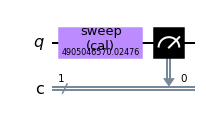

In [7]:
sweep_gate = Gate("sweep", 1, [freq])

qc_sweep = QuantumCircuit(1, 1)

qc_sweep.append(sweep_gate, [0])
qc_sweep.measure(0, 0)
qc_sweep.add_calibration(sweep_gate, (0,), sweep_sched, [freq])

# Create the frequency settings for the sweep (MUST BE IN HZ)
frequencies_Hz = frequencies_GHz*GHz
exp_sweep_circs = [qc_sweep.assign_parameters({freq: f}, inplace=False) for f in frequencies_Hz]
exp_sweep_circs[0].draw(output='mpl')

In [8]:
num_shots_per_frequency = 1024

sweep_job = backend.run(exp_sweep_circs,
                  meas_level=1,
                  meas_return='avg',
                  shots=num_shots_per_frequency)
sweep_job.job_id()


'6360b59dec45f9623c8791b7'

### Job id
01/11/22:'6360b59dec45f9623c8791b7'


In [6]:
sweep_job = backend.retrieve_job('6360b59dec45f9623c8791b7')

In [8]:
frequency_sweep_results = sweep_job.result(timeout=120) 

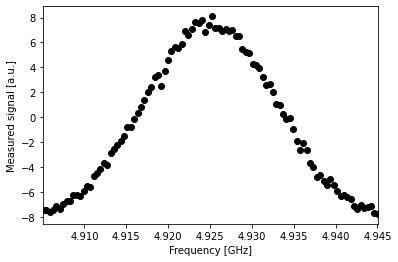

In [13]:
sweep_values = []
for i in range(len(frequency_sweep_results.results)):
    # Get the results from the ith experiment
    res = frequency_sweep_results.get_memory(i)*scale_factor
    # Get the results for `qubit` from this experiment
    sweep_values.append(res[0])

plt.scatter(frequencies_GHz, np.real(sweep_values), color='black') # plot real part of sweep values
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])
plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured signal [a.u.]")
plt.show()

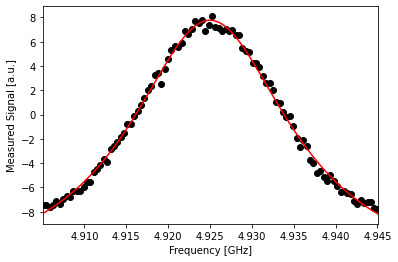

array([ 7.90540104e-01,  4.92499352e+00,  1.17431489e-02, -1.36517662e+01])

In [26]:
fit_params, y_fit = fit_function(frequencies_GHz,
                                 np.real(sweep_values), 
                                 lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                 [8, 4.925, 1, -8] # initial parameters for curve_fit
                                )

plt.scatter(frequencies_GHz, np.real(sweep_values), color='black')
plt.plot(frequencies_GHz, y_fit, color='red')
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])

plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured Signal [a.u.]")
plt.show()
fit_params

In [28]:
A, rough_qubit_frequency, B, C = fit_params
rough_qubit_frequency = rough_qubit_frequency*GHz # make sure qubit freq is in Hz
print(f"We've updated our qubit frequency estimate from "
      f"{backend_defaults.qubit_freq_est[qubit]} Hz to {rough_qubit_frequency} Hz.")

We've updated our qubit frequency estimate from 4925046570.024763 Hz to 4924993522.1397295 Hz.


In [11]:
f01 = 4924993522.1397295

## Rabi 01

In [4]:
# This experiment uses these values from the previous experiment:
# `qubit`,and
# `rough_qubit_frequency`.

# Rabi experiment parameters
num_rabi_points = 100

# Drive amplitude values to iterate over: 50 amplitudes evenly spaced from 0 to 0.75
drive_amp_min = 0
drive_amp_max = 0.75
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)
# f01 = 4924993522.1397295
f01 = backend_defaults.qubit_freq_est[qubit]

In [25]:
# Build the Rabi experiments:
#    A drive pulse at the qubit frequency, followed by a measurement,
#    where we vary the drive amplitude each time.
drive_sigma_sec = 0.015 * us                           # This determines the actual width of the gaussian
drive_duration_sec = drive_sigma_sec * 8


drive_amp = Parameter('drive_amp')
with pulse.build(backend=backend, default_alignment='sequential', name='Rabi Experiment') as rabi_sched:
    drive_duration = 320
    drive_sigma = 80
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(f01, drive_chan)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=drive_amp,
                              sigma=drive_sigma,
                              name='Rabi Pulse'), drive_chan)

In [26]:
rabi_gate = Gate("rabi", 1, [drive_amp])

qc_rabi = QuantumCircuit(1, 1)

qc_rabi.append(rabi_gate, [0])
qc_rabi.measure(0, 0)
qc_rabi.add_calibration(rabi_gate, (0,), rabi_sched, [drive_amp])

exp_rabi_circs = [qc_rabi.assign_parameters({drive_amp: a}, inplace=False) for a in drive_amps]

In [27]:
num_shots_per_point = 20000

rabi01_job = backend.run(exp_rabi_circs, 
                  meas_level=1,
                  meas_return='avg',
                  shots=num_shots_per_point)

rabi01_job.job_id()

'63614b2a0f4ec79e1e651375'

### Job id:
01/11/22: '63614b2a0f4ec79e1e651375'

In [5]:
rabi01_job = backend.retrieve_job('63614b2a0f4ec79e1e651375')

In [6]:
rabi_results = rabi01_job.result()

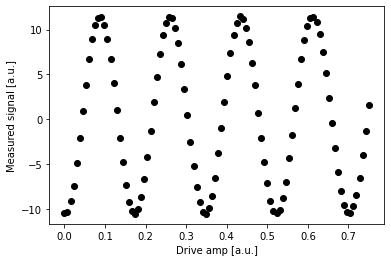

In [10]:
def baseline_remove(values):
    return np.array(values) - np.mean(values)

rabi_values = []
for i in range(num_rabi_points):
    # Get the results for `qubit` from the ith experiment
    rabi_values.append(rabi_results.get_memory(i)[0] * scale_factor)

rabi_values = np.real(baseline_remove(rabi_values))

plt.xlabel("Drive amp [a.u.]")
plt.ylabel("Measured signal [a.u.]")
plt.scatter(drive_amps, rabi_values, color='black') # plot real part of Rabi values
plt.show()

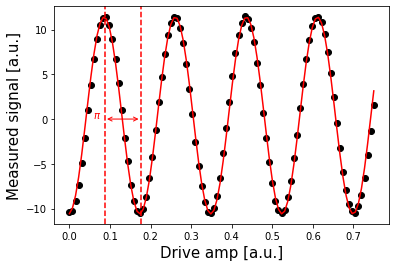

In [11]:
fit_params, y_fit = fit_function(drive_amps,
                                 rabi_values, 
                                 lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B),
                                 [15, 0, 0.15, np.pi])

plt.scatter(drive_amps, rabi_values, color='black')
plt.plot(drive_amps, y_fit, color='red')

drive_period = fit_params[2] # get period of rabi oscillation

plt.axvline(drive_period/2, color='red', linestyle='--')
plt.axvline(drive_period, color='red', linestyle='--')
plt.annotate("", xy=(drive_period, 0), xytext=(drive_period/2,0), arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=(drive_period/2-0.03, 0.1), color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.show()

In [12]:
X01_amp = abs(drive_period / 2)
print(f"Pi Amplitude = {X01_amp}")

Pi Amplitude = 0.08766575883814695


# Overrotation experiment

In [67]:
def overrot_circs(x01_amp):
    with pulse.build(backend=backend, default_alignment='sequential', name=r'$X_{\pi}^{(01)}$') as X01_Gaussian_sched:
        drive_chan = pulse.drive_channel(qubit)
        pulse.set_frequency(f01, drive_chan)
        pulse.play(pulse.Gaussian(duration=x_duration,
                                amp=x01_amp,
                                sigma=x_sigma,
                                name=r'$X_{\pi}^{(01)}$'), drive_chan)
    
    re_circs = []
    for i in range(100):
        qc_re = QuantumCircuit(1, 1)
        X01_Gaussian = Gate("$X_\pi^{01}$", 1, [])
        qc_re.add_calibration(X01_Gaussian, (0,), X01_Gaussian_sched, [])
        qc_re.append(X01_Gaussian, [0])
        for j in range(i):
            qc_re.append(X01_Gaussian, [0])
        qc_re.measure(qubit, 0)
        re_circs.append(qc_re)
    return re_circs

In [66]:
x01_amp = 0.08602764657895232

In [68]:
re_job = backend.run(overrot_circs(x01_amp),
                    meas_level=2,
                    meas_return='single',
                    shots=20000)
re_job.job_id()

'636d1f2f754e4634fb4ce454'

job id 
10/11/22:  '636c741d718d1151a7630cca' eps = 0.026853754547430636, amp = 0.08692275912573019
           '636d0b48754e46c9824ce411' eps = 0.014222391860302382, amp = 0.08653102211831362
           '636d18e10565beac0500762d' eps = 0.018382473069316667, amp = 0.08602764657895232
           '636d1f2f754e4634fb4ce454' 

In [103]:
re_job = backend.retrieve_job('636d0b48754e46c9824ce411')

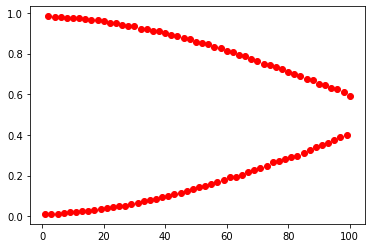

In [104]:
zero_population = [res['0']/20000 for res in re_job.result().get_counts()]
plt.scatter(range(1, 101), zero_population, marker='o', linestyle='-', color= 'red')

epsilon = -0.014222391839604161
r-squared = 0.9980010037423825


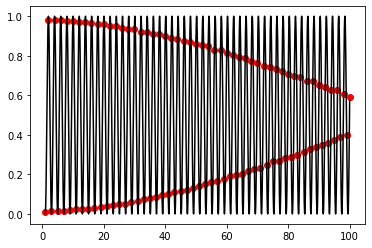

In [105]:
from sklearn.metrics import r2_score

def population_theory(n, eps):
    return 1/2*np.cos(n*(np.pi + eps)) + 1/2
params = curve_fit(population_theory, range(1, 101), zero_population, [-0.01], maxfev = 50000)[0]
eps = params[0]
print('epsilon =', eps)
m = 100
x_val = np.linspace(1, m, 10000)
plt.scatter(range(1, m + 1), zero_population[0:m], marker='o', linestyle='-', color= 'red')
plt.plot(x_val, population_theory(x_val, *params), color= 'black')

zero_population_theory = population_theory(range(1,101), *params)
print('r-squared =', r2_score(zero_population, zero_population_theory))

In [98]:
x01_amp = 0.08602764657895232
x01_amp_corrected = np.pi/(np.pi + eps)*x01_amp
print('epsilon =', eps)
print('corrected amp =', x01_amp_corrected)
print('x01_amp is corrected by ' +  str(np.abs((x01_amp_corrected - x01_amp))/x01_amp*100) + '%')


epsilon = -0.03472593122744784
corrected amp = 0.08698919092755843
x01_amp is corrected by 1.1177155098897755%
